## Synopsis

This code generates the SAXS 2D and 1D figure (water) for the manuscript

## Initialize

In [1]:

import numpy as np
from numpy import sqrt, sin, cos, pi, exp
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import h5py  
from scipy.optimize import curve_fit
import scipy.integrate as integrate
from xpcs_viewer import XpcsFile as xf

mpl.rcParams['legend.handlelength'] = 2


## Load result files

In [2]:

fn_path = '../Reduced_Data/'

Water = xf('J058_Water_SAXS_Abs_Cross.hdf', cwd = fn_path)
NaCl = xf('L067_NaCl_SAXS_Abs_Cross.hdf', cwd = fn_path)
NH4 = xf('M071_NH4_SAXS_Abs_Cross.hdf', cwd = fn_path)

# The value in hdf file is wrong but the q's in Q map is right, as the detector distance was manually corrected
det_dist = 7800   

pix2q = Water.pix_dim_x/det_dist*(2*3.1416/(12.4/Water.X_energy))


## Calculate I(Q) for hard sphere
The fit is eyeballed since there is no explicit function form for I(Q)

In [3]:

I_Corr = 0.96

rad_coeff=np.zeros([2])

I_cal=np.zeros(len(Water.ql_sta))

R_NP = 130
d_NP = 12

for ii in np.arange(len(Water.ql_sta)):
    ql = Water.ql_sta[ii]
#     I_size = lambda x: (sin(ql*x)-ql*x*cos(ql*x))**2 / (ql*x)**6*exp(-(x-R_NP)**2/(2*d_NP**2))

    I_size = lambda x: (4.0/3.0*3.14*x**3)**2 * ((sin(ql*x)-ql*x*cos(ql*x))/(ql*x)**3)**2 * exp(-(x-R_NP)**2/(2*d_NP**2))

    _ = integrate.quad(I_size, 0, 1000)
    I_cal[ii] = _[0]

Iq_fit = I_Corr*I_cal/np.max(I_cal)*np.max(Water.saxs_1d['Iq'])    


## Stack up 2D SAXS and 1D SAXS

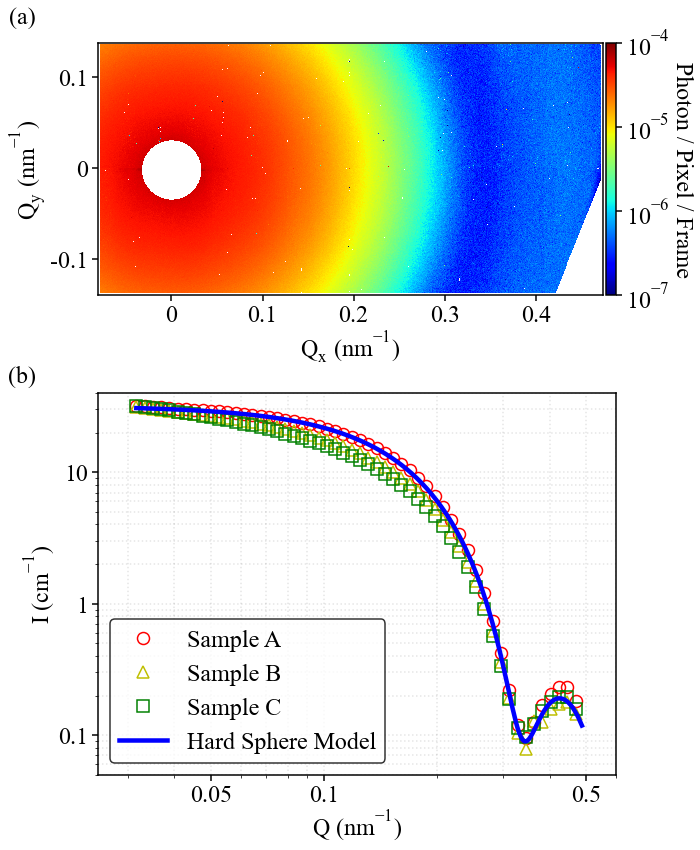

In [5]:

# figure parameter settings. 
# 3.3 inch is about 85 mm。 Not sure why 2.4 inch produces ~86 mm figure
# Use scale=1 for production figure and scale=3 for viewing in Jupyter Notebook
scale = 3
width = 2.4*scale
font_size = 8*scale
line_width = 0.5*scale
marker_size = 4*scale
tick_length_major = 2*scale
tick_length_minor = 1*scale

### Set up canvas. ax1 is 2D SAXS and ax2 is 1D SAXS
%matplotlib inline
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(width, 1.6*width))
plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['axes.linewidth'] = line_width

### Plot ax1 (2D SAXS)
Q_y_max = (Water.saxs_2d.shape[0]-Water.ccd_y0)*pix2q
Q_y_min = -Water.ccd_y0*pix2q
Q_x_min = (Water.ccd_x0-Water.saxs_2d.shape[1])*pix2q
Q_x_max = Water.ccd_x0*pix2q
im = ax1.imshow(np.rot90(Water.saxs_2d), cmap='jet', norm=LogNorm(vmin=1e-7, vmax=1e-4),
               interpolation='none', extent=([Q_y_min, Q_y_max, Q_x_min, Q_x_max]))

### Add color bar
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="2%", pad=0.05)
cbar = fig.colorbar(im, cax=cax, ticks=[1e-7, 1e-6, 1e-5, 1e-4])
cbar.ax.tick_params('y', length=tick_length_major, width=line_width, labelsize=font_size, which='major')
cbar.ax.minorticks_off()
cbar.set_label('Photon / Pixel / Frame', rotation=270, fontsize=font_size, labelpad=font_size)

### Adjust ax1 (ticks, labels and strokes)
ax1.set_xticks([0, 0.01, 0.02, 0.03, 0.04])
ax1.set_xticklabels([0, 0.1, 0.2, 0.3, 0.4], fontsize = font_size)
ax1.set_xlabel('Q$\mathdefault{_x}$ (nm$\mathdefault{^{-1}}$)', fontsize=font_size, labelpad=0.05*font_size)
ax1.set_yticks([-0.01, 0, 0.01])
ax1.set_yticklabels([-0.1, 0, 0.1], fontsize = font_size)
ax1.set_ylabel('Q$\mathdefault{_y}$ (nm$\mathdefault{^{-1}}$)', fontsize=font_size, labelpad=0.05*font_size)
ax1.tick_params('both', length=tick_length_major, width=line_width, which='major')
ax1.tick_params('x', length=tick_length_minor, width=0.5*line_width, which='minor')
for axis in ['top','bottom','left','right']:
    ax1.spines[axis].set_linewidth(line_width)

### Plot ax2 (1D SAXS)
ax2.plot(Water.ql_sta, np.squeeze(Water.saxs_1d['Iq']), color='r', fillstyle='none', 
    marker='o', markersize=marker_size, markevery=5, markeredgewidth=line_width, 
        linestyle="None", label='Sample A')
ax2.plot(NaCl.ql_sta, np.squeeze(NaCl.saxs_1d['Iq']), color='y', fillstyle='none', 
    marker='^', markersize=marker_size, markevery=5, markeredgewidth=line_width,
        linestyle="None", label='Sample B')
ax2.plot(NH4.ql_sta, np.squeeze(NH4.saxs_1d['Iq']), color='g', fillstyle='none', 
    marker='s', markersize=marker_size, markevery=5, markeredgewidth=line_width, 
        linestyle="None", label='Sample C')        
ax2.plot(np.squeeze(Water.ql_sta), Iq_fit, color='b', 
        linestyle="-", linewidth=line_width*3, label='Hard Sphere Model')
ax2.set_aspect(0.35)

### Adjust ax1 ticks, labels and strokes
ax2.tick_params('both', length=tick_length_major, width=line_width, which='major')
ax2.tick_params('both', length=tick_length_minor, width=0.5*line_width, which='minor')
for axis in ['top','bottom','left','right']:
    ax2.spines[axis].set_linewidth(line_width)
ax2.grid(color='k', linestyle=':', linewidth=line_width, alpha=0.1, which='both')

ax2.set_xscale('log')
ax2.set_xlim(2.5e-3, 6e-2)
ax2.set_xticks([5e-3, 1e-2, 5e-2])
ax2.set_xticklabels([0.05, 0.1, 0.5], fontsize = font_size)
ax2.set_xlabel('Q (nm$\mathdefault{^{-1}}$)', fontsize=font_size, labelpad=0.05*font_size)

ax2.set_yscale('log')
ax2.set_ylim(5e-2, 4e1)
ax2.set_yticks([1e-1, 1e0, 1e1])
ax2.set_yticklabels([0.1, 1, 10], fontsize = font_size)
ax2.set_ylabel('I (cm$\mathdefault{^{-1}}$)', fontsize=font_size, labelpad=0.05*font_size)

### Add legend
legend=ax2.legend(fancybox=True, fontsize=font_size, loc=3)
legend.get_frame().set_edgecolor('k')
legend.get_frame().set_linewidth(line_width)

### Add labels for the figures
ax1.text(-0.15, 1.1, '(a)',  fontsize = font_size, horizontalalignment='center',
         verticalalignment='center', transform=ax1.transAxes)
ax1.text(-0.15, -0.32, '(b)',  fontsize = font_size, horizontalalignment='center',
         verticalalignment='center', transform=ax1.transAxes)

### Save figure
plt.savefig('SAXS_Stack.pdf', dpi=600, format='pdf', 
            facecolor='w', edgecolor='w', transparent=False, bbox_inches='tight')